<center><img src="http://www.ozyegin.edu.tr/sites/default/files/upload/Basin/ou_logo_tr.jpg"></center>

<center><h1>Predictive Analytics (IE 529)</h1></center>
<center><h2>Tutorial 2: Classical and STL Decomposition </h2></center>
<center><h4>(I would like to thank Prof. Marcel Scharth for an earlier version of this tutorial.)</h4></center>
<br>

In this tutorial we will study how to apply classical and STL decomposition  in Python. 

<a class="buttom" href=">#Data:-NSW-retail-turnover">Data: NSW retail turnover</a> <br>
<a class="buttom" href="#Time-series-decomposition">Time series decomposition</a> <br>
This notebook relies on the following imports and settings

In [60]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [61]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

##Data: NSW Retail turnover

In this tutorial we will keep working with the Australian retail turnover series. The next cells load the data and reproduces some of the steps from last tutorial. 

In [62]:
data = pd.read_csv('nswretail.csv', index_col='Month', parse_dates=True, dayfirst=True)
data.tail()

,Turnover
Month,
2018-10-01,8747.3
2018-11-01,9245.0
2018-12-01,11085.5
2019-01-01,8651.0
2019-02-01,7717.4


In [63]:
data.describe().round(2)

,Turnover
count,443.00
mean,4389.23
std,2212.93
min,1214.50
25%,2574.50
50%,3961.90
75%,6038.75
max,11085.50


In [65]:
y = data['Turnover'].copy()
y=y['2005':]
y.index = y.index.to_period(freq='M')
ts = data['Turnover']

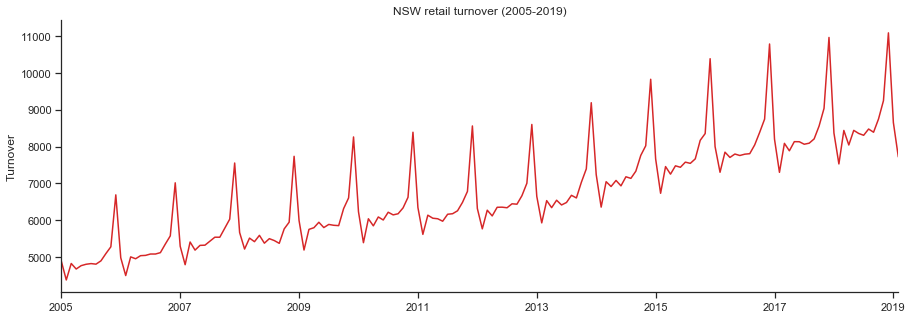

In [66]:
fig, ax= plt.subplots(figsize=(15,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('NSW retail turnover (2005-2019)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

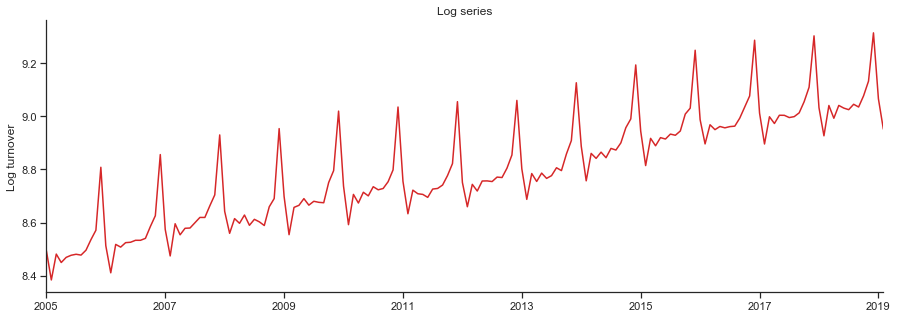

In [67]:
fig, ax= plt.subplots(figsize=(15,5))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log turnover')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

##Box-Cox Transformation

Let's use a BoxCox transformation to stabilize variance. The following code finds that the optimal lambda is -0.47487. We could round this number to -0.5 for explainability. At the same time, we create a 95% confidence interval for lambda, to account for sampling error. Indeed, any point in this interval could be used.   

In [95]:
transf,lambda_1,ConfInt=stats.boxcox(y,alpha=0.05)
print(lambda_1)
print(ConfInt)

-0.47487136990986045
(-1.2113827634530756, 0.24540349586944846)


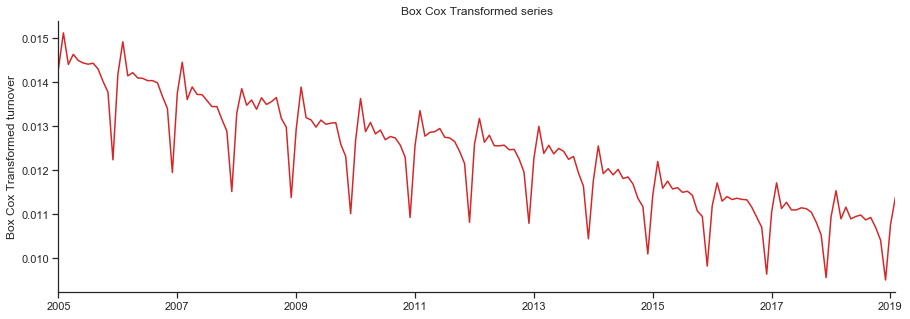

In [96]:
fig, ax= plt.subplots(figsize=(15,5))
np.power(y,-0.5).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Box Cox Transformed turnover')
ax.set_title('Box Cox Transformed series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

##Time series decomposition

We use the classical method for time series decomposition. 

In [24]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

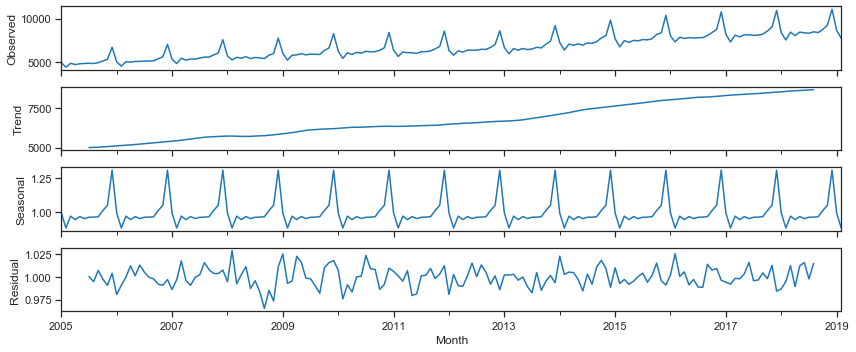

In [88]:
decomposition =  seasonal_decompose(y, model='mult',period=12)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(decomposition, axes)

plt.tight_layout()
plt.show()

You can use the <TT>dir</TT> method to check the available output. 

In [81]:
dir(decomposition)[-6:]

['observed', 'plot', 'resid', 'seasonal', 'trend', 'weights']

Let's see the seasonal factors.

In [82]:
decomposition.seasonal[-24:]

Month
2017-03    0.972592
2017-04    0.947123
2017-05    0.969410
2017-06    0.954735
2017-07    0.964420
2017-08    0.965197
2017-09    0.968600
2017-10    1.013726
2017-11    1.052673
2017-12    1.310610
2018-01    0.995323
2018-02    0.885590
2018-03    0.972592
2018-04    0.947123
2018-05    0.969410
2018-06    0.954735
2018-07    0.964420
2018-08    0.965197
2018-09    0.968600
2018-10    1.013726
2018-11    1.052673
2018-12    1.310610
2019-01    0.995323
2019-02    0.885590
Freq: M, Name: seasonal, dtype: float64

Notice that the sesonality is constant, it does not change from year to year. 

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [83]:
seasadj=np.divide(decomposition.observed,decomposition.seasonal)

In [84]:
seasadj.tail()

Month
2018-10    8628.858692
2018-11    8782.404532
2018-12    8458.272901
2019-01    8691.647279
2019-02    8714.414279
Freq: M, dtype: float64

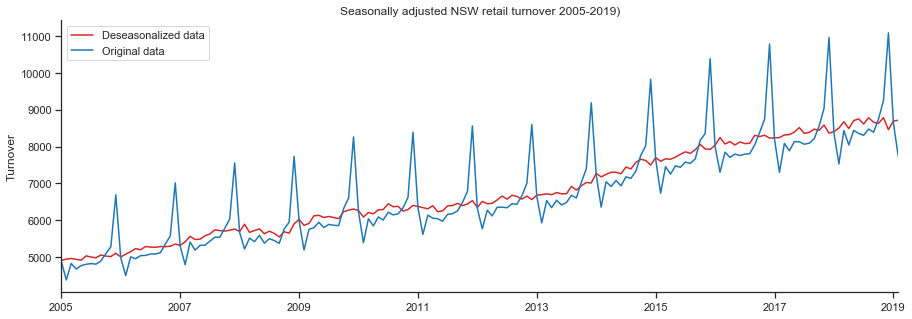

In [85]:
fig, ax= plt.subplots(figsize=(15,5))
seasadj.plot(color=red,label='Deseasonalized data')
y.plot(color=blue,label='Original data')
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally adjusted NSW retail turnover 2005-2019)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

## STL Decomposition

Let's apply STL decomposition. Since it only handles additive decomposition, we use it after the data is log-transformed. seasonal and trend arguments of this function handles how much smoothness you want in the seasonal and trend components, higher numbers mean a more smoothed curve. Try for yourself.

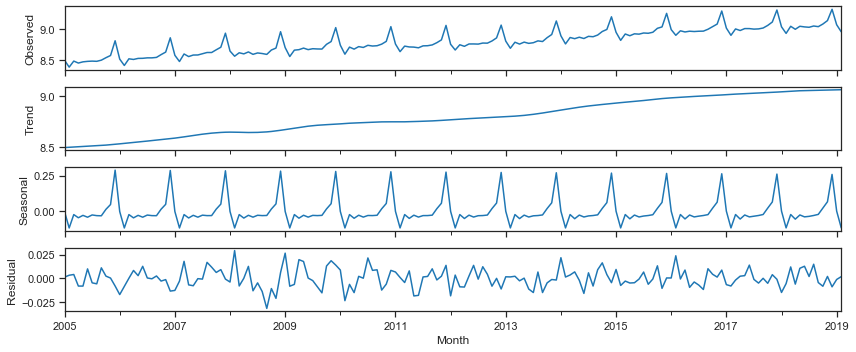

In [97]:
from statsmodels.tsa.seasonal import STL
STL_Dec = STL(np.log(y),period=12,seasonal=77,trend=19).fit()

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(STL_Dec, axes)

plt.tight_layout()
plt.show()

In [98]:
STL_Dec.seasonal[-24:]

Month
2017-03   -0.023097
2017-04   -0.054632
2017-05   -0.026264
2017-06   -0.039613
2017-07   -0.035050
2017-08   -0.029843
2017-09   -0.022897
2017-10    0.021853
2017-11    0.064973
2017-12    0.260289
2018-01    0.001113
2018-02   -0.116743
2018-03   -0.023026
2018-04   -0.055391
2018-05   -0.026043
2018-06   -0.039364
2018-07   -0.035817
2018-08   -0.029768
2018-09   -0.022121
2018-10    0.022551
2018-11    0.066468
2018-12    0.257936
2019-01    0.001347
2019-02   -0.116696
Freq: M, Name: season, dtype: float64

Notice that with STL the sesonality is NOT constant, it does change from year to year. 